<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/py_torch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorhc workflow

Let's explore an example PyTorch end-to-end workflow




In [1]:
import torch
from torch import nn # nn contains all of Pytorch's building blocks of neural networks
import matplotlib.pyplot as plt

In [2]:
# Check Pytorch version
torch.__version__

'2.3.0+cu121'

## 1. Data (preparing and loading)


In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [5]:
X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

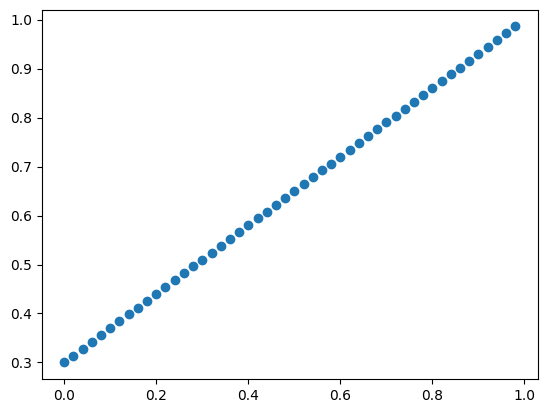

In [4]:
plt.scatter(X, y)
plt.show()

### Splitting dta into training and test sets

In [8]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [9]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [11]:
def plot_prediction(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

    # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
  if predictions is not None:
        # Plot the predictions if they exist
      plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})
  plt.show()


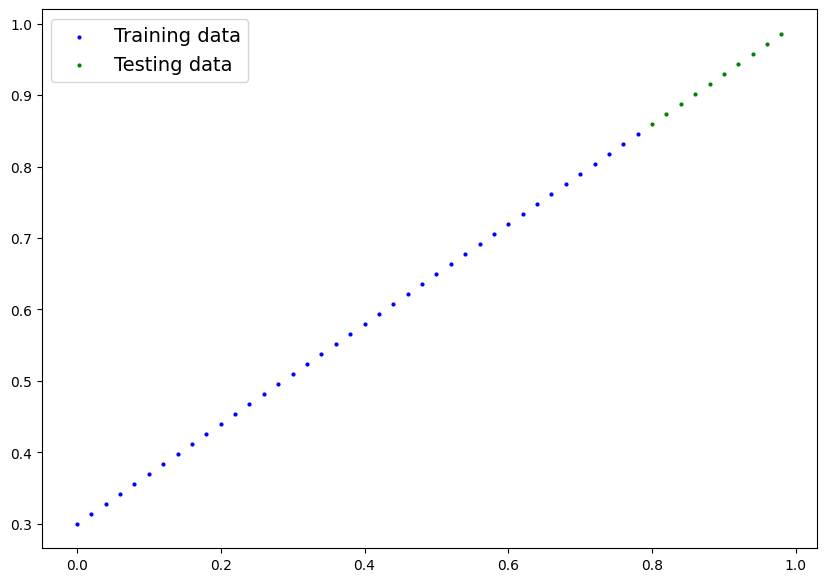

In [12]:
plot_prediction()

## 2. Build model

In [26]:
# Cerate a linear regression model class

class LinearRegresionModel(nn.Module): # <- almost everything in Pytorch inherents from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(
            1, # <- start with a random weight and try to adjuts it to the ideal weight
            requires_grad=True, # <- can this parameter be updated via gradient descent?
            dtype=torch.float, # PyTorch loves the dattype torch.float32
            ),
        )

        self.bias = nn.Parameter(torch.randn(1,
            requires_grad=True,
            dtype=torch.float,
            ),
        )

    # Forward method to define teh computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data1
        return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

### Checking the content of our PyTorch model

In [28]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegresionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [29]:
# List named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediciton using `torch.inference_mode()`

In [34]:
# Make predicitions with mode

with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

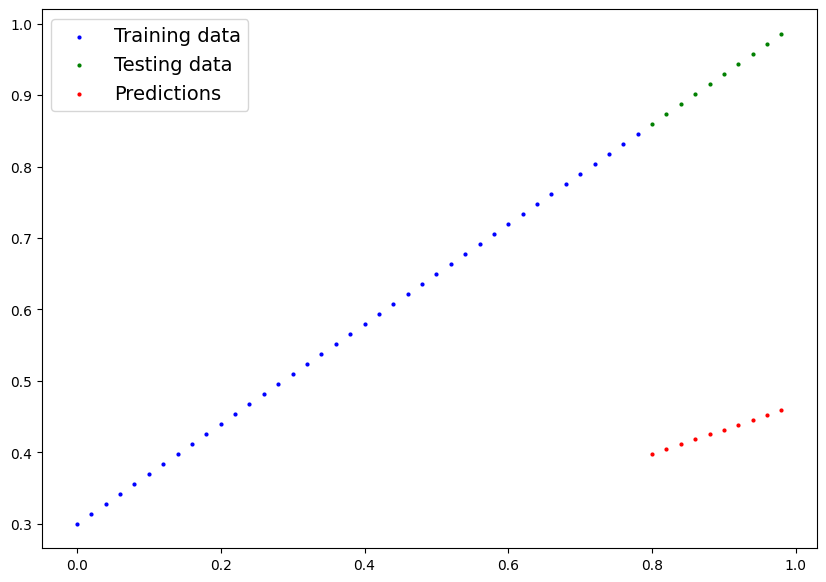

In [35]:
plot_prediction(predictions=y_preds)

In [36]:
with torch.no_grad():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

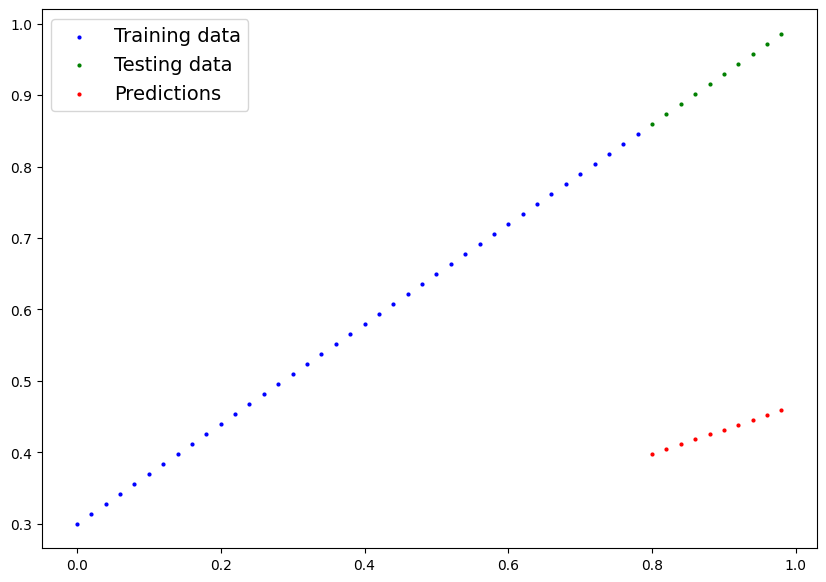

In [37]:
plot_prediction(predictions=y_preds)

## 3. Train model

In [39]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # lr= learning rate

### Building a trainig loop (and testing loop) in PyTorch

In [52]:
torch.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []

epochs = 200

### Training
# 0. Loop trhough the data
for epoch in range(epochs):
  model_0.train() # train mode in PyTorch

  # Forward pass
  y_pred = model_0(X_train)

  # Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Perform backpropagation on the loss with respect to the parameters of the mdoel
  loss.backward()

  # Step teh optimizer (perform gradient descent)
  optimizer.step() # by default hoe the optimizer changes will acumulate through the loop soo... we have to zero them above in step 3

  # Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation

  with torch.inference_mode():
     # 1. Do the forward pass
     test_pred = model_0(X_test)

     # 2. Calculate the loss
     test_loss = loss_fn(test_pred, y_test.unsqueeze(dim=1))

     # Print out what's happening
     if epoch % 10 == 0:

        epoch_count.append(epoch)

        loss_values.append(loss.detach().numpy())

        test_loss_values.append(test_loss.detach().numpy())

        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

        print(model_0.state_dict())

  print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.02102 | Test loss: 0.05885
OrderedDict([('weights', tensor([0.5972])), ('bias', tensor([0.3433]))])
Epoch: 0 | Loss: 0.02102 | Test loss: 0.05885
Epoch: 1 | Loss: 0.02068 | Test loss: 0.05864
Epoch: 2 | Loss: 0.02034 | Test loss: 0.05802
Epoch: 3 | Loss: 0.01999 | Test loss: 0.05782
Epoch: 4 | Loss: 0.01965 | Test loss: 0.05723
Epoch: 5 | Loss: 0.01930 | Test loss: 0.05664
Epoch: 6 | Loss: 0.01896 | Test loss: 0.05645
Epoch: 7 | Loss: 0.01862 | Test loss: 0.05588
Epoch: 8 | Loss: 0.01827 | Test loss: 0.05569
Epoch: 9 | Loss: 0.01793 | Test loss: 0.05514
Epoch: 10 | Loss: 0.01759 | Test loss: 0.05496
OrderedDict([('weights', tensor([0.6141])), ('bias', tensor([0.3358]))])
Epoch: 10 | Loss: 0.01759 | Test loss: 0.05496
Epoch: 11 | Loss: 0.01725 | Test loss: 0.05443
Epoch: 12 | Loss: 0.01690 | Test loss: 0.05426
Epoch: 13 | Loss: 0.01656 | Test loss: 0.05375
Epoch: 14 | Loss: 0.01621 | Test loss: 0.05327
Epoch: 15 | Loss: 0.01587 | Test loss: 0.05311
Epoch: 16 | Loss: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [48]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5954])), ('bias', tensor([0.3438]))])

In [49]:
weight, bias

(0.7, 0.3)

In [53]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

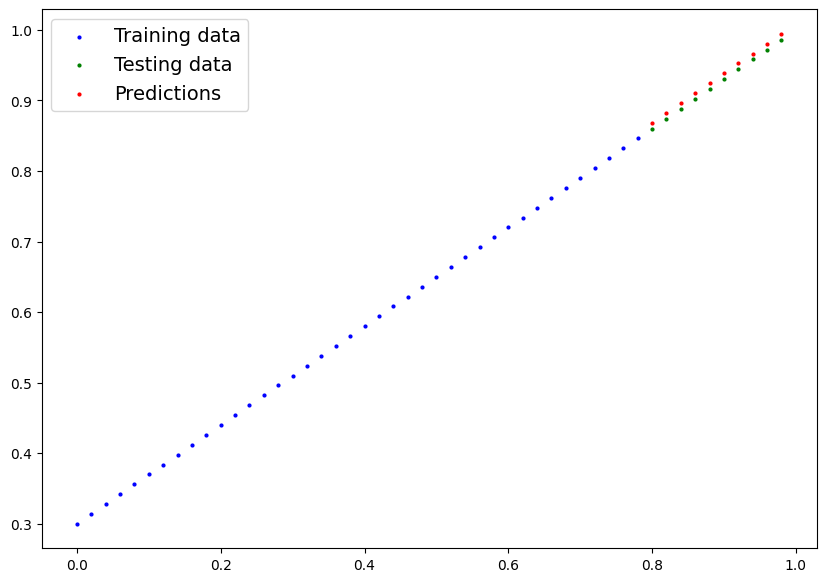

In [54]:
plot_prediction(predictions=y_preds)

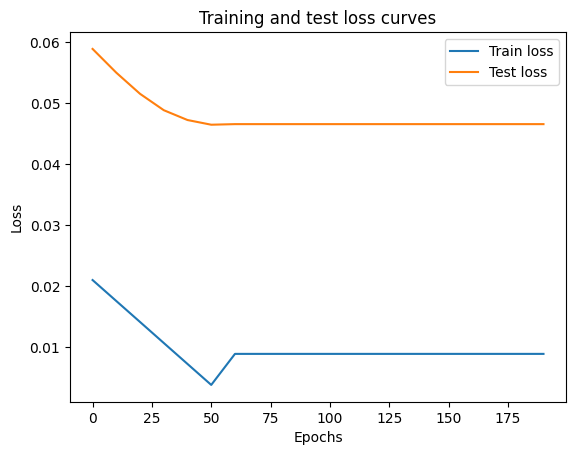

In [58]:
import numpy as np

plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

### Save the model

In [59]:
torch.save(obj=model_0.state_dict(), f="01_pytorch_workflow_model_0.pth")

In [60]:
loaded_model_0 = LinearRegresionModel()

loaded_model_0.load_state_dict(torch.load("01_pytorch_workflow_model_0.pth"))

<All keys matched successfully>

In [61]:
loaded_model_preds = loaded_model_0(X_test)

In [66]:
loaded_model_preds.detach()

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

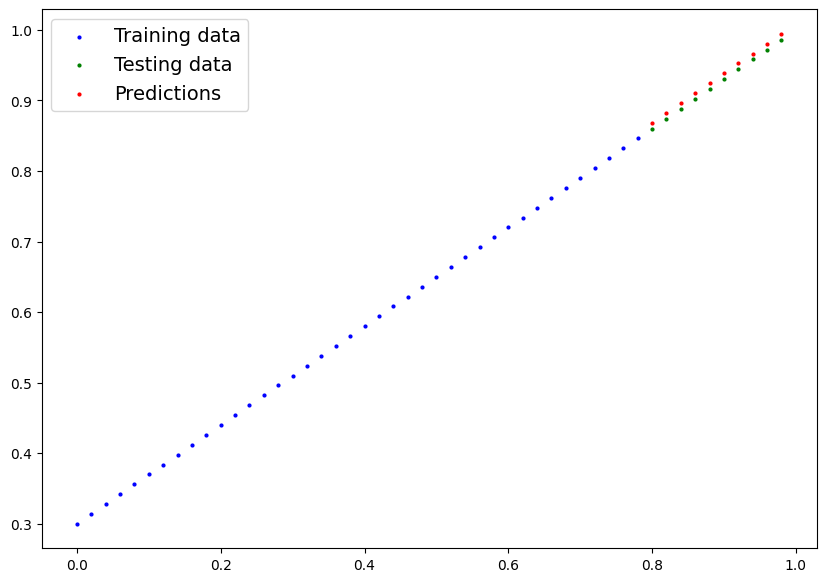

In [67]:
plot_prediction(predictions=loaded_model_preds.detach())

## Puting it all together

#### 6.1 Data

In [68]:
# setup agnodtic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [70]:
# Create some data
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels()
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [71]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [72]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

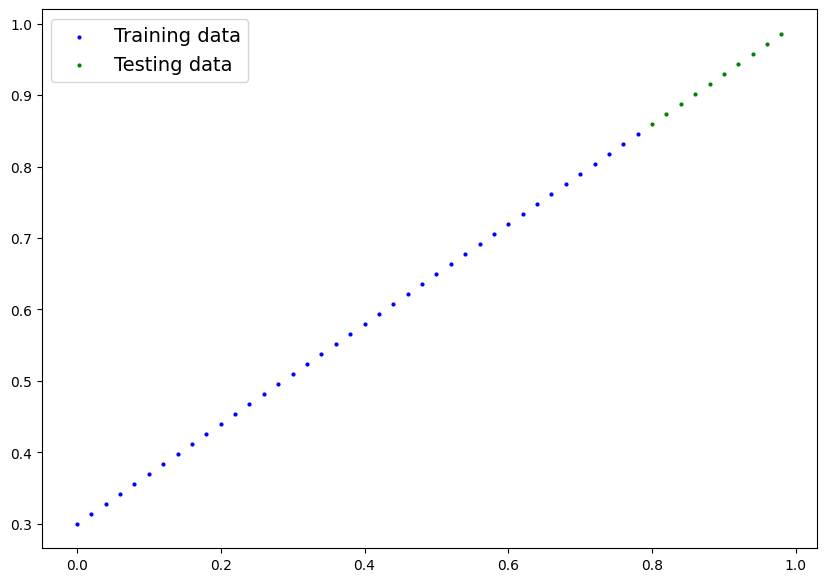

In [73]:
# Plot the data
plot_prediction()

### 6.2 Build aPyTorch Linear model

In [74]:
# Create a linear model by subclass nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
      super().__init__()
      ## Use nn.Linear() for creating the mdoel pareameters

      self.linear_layer = nn.Linear(in_features=1,
                                   out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [75]:
# Check the mdoel current device
next(model_1.parameters()).device

device(type='cpu')

In [76]:
# Set the mdoel to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

In [77]:
# Loss function
loss_fn = nn.L1Loss()

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [79]:
# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [80]:
# Let's write training loop

torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):
  ## Training
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the mdoel
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Do the predictions
    test_preds = model_1(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_preds, y_test)

    # Print out whats's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")
      print(model_1.state_dict())
      print()


Epoch: 0 | Loss: 0.55518 | Test loss: 0.57398
OrderedDict([('linear_layer.weight', tensor([[0.7606]], device='cuda:0')), ('linear_layer.bias', tensor([0.8200], device='cuda:0'))])

Epoch: 10 | Loss: 0.43997 | Test loss: 0.43927
OrderedDict([('linear_layer.weight', tensor([[0.7216]], device='cuda:0')), ('linear_layer.bias', tensor([0.7200], device='cuda:0'))])

Epoch: 20 | Loss: 0.32476 | Test loss: 0.30456
OrderedDict([('linear_layer.weight', tensor([[0.6826]], device='cuda:0')), ('linear_layer.bias', tensor([0.6200], device='cuda:0'))])

Epoch: 30 | Loss: 0.20955 | Test loss: 0.16985
OrderedDict([('linear_layer.weight', tensor([[0.6436]], device='cuda:0')), ('linear_layer.bias', tensor([0.5200], device='cuda:0'))])

Epoch: 40 | Loss: 0.09434 | Test loss: 0.03514
OrderedDict([('linear_layer.weight', tensor([[0.6046]], device='cuda:0')), ('linear_layer.bias', tensor([0.4200], device='cuda:0'))])

Epoch: 50 | Loss: 0.02389 | Test loss: 0.04785
OrderedDict([('linear_layer.weight', tensor(

In [81]:
model_1_preds = model_1(X_test)

In [82]:
model_1_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0', grad_fn=<AddmmBackward0>)

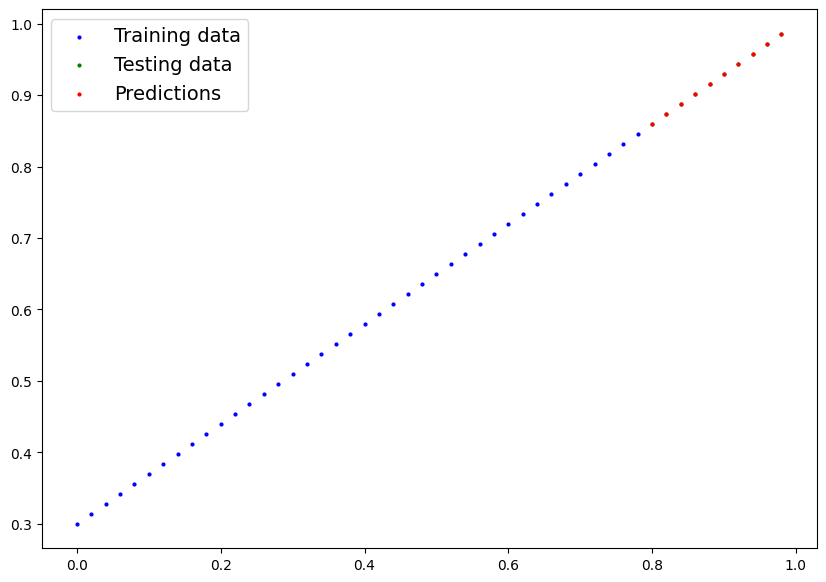

In [85]:
plot_prediction(predictions=model_1_preds.cpu().detach())

In [86]:
from pathlib import Path

# 1. Create a directory to save model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save
MODEL_NAME = "pytorhc_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

In [87]:
# load saved model

model_1_loaded = LinearRegressionModelV2()
model_1_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

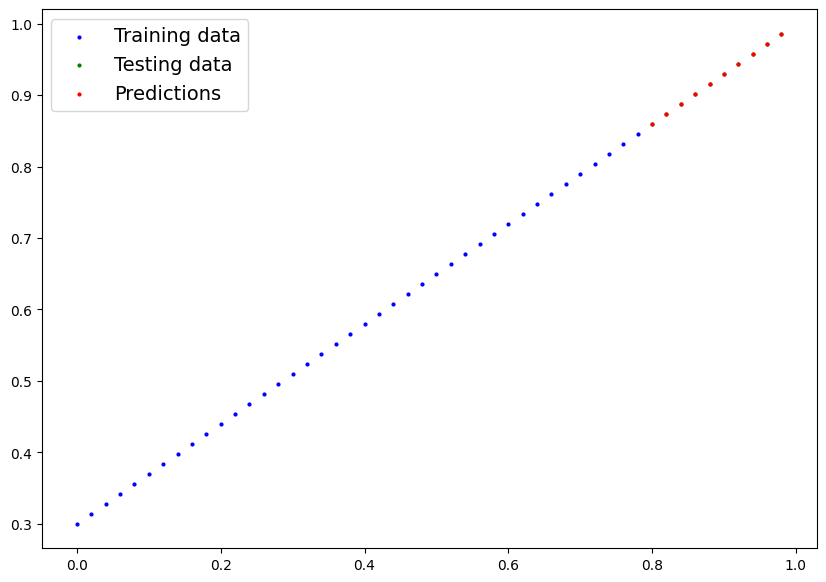

In [89]:
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

model_1_lloaded_preds = model_1_loaded(X_test)

plot_prediction(predictions=model_1_lloaded_preds.cpu().detach())